In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/
root_path = 'gdrive/My Drive/'
os.chdir('gdrive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


Imports:


In [9]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras.preprocessing
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

Utils to use in this jupyter:

In [31]:
def df_to_tensor(df):
  rev_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e) for e in df.review])
  sent_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e, dtype=tf.int64) for e in df.sentiment])
  return tf.data.Dataset.zip((rev_tensor, sent_tensor)).prefetch(1)

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 1000)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

def plot_metric(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#to re-write:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return (predictions)

## Loading data

First we load the data from the repository that I created:

In [4]:
data_url = 'https://raw.githubusercontent.com/DavidCarricondo/Custom-database-goodreads-reviews/master/DATA/goodreads_reviews_clean.csv'
data = pd.read_csv(data_url)
data.head()

,review,grade,lang,score,sentiment
0,"The statue of Hadrian, the 14th Emperor of the...",it was amazing,en,4,2
1,It's hard to know what to think about this boo...,really liked it,en,3,2
2,"If you're into stuff like this, you can read t...",it was amazing,en,4,2
3,Has Kenzaburo Oe ever visited Japan? Ban this ...,it was amazing,en,4,2
4,Sadza (typical cornmeal staple food in Zimbabw...,it was amazing,en,4,2


Now, let's shuffle the data and then split it into train, validation, and test data (90%, 5%, 5% respectively), and then convert it to tensorflow tensors

In [32]:
data = data.sample(frac=1).reset_index(drop=True)

train_size = len(data) * 90//100
valtest_size = (len(data)-train_size)//2

data_train = data[:train_size]
data_val = data[train_size:(train_size+valtest_size)]
data_test = data[(train_size+valtest_size):]

In [33]:
data_train = df_to_tensor(data_train)
data_val = df_to_tensor(data_val)
data_test = df_to_tensor(data_test)

In [8]:
type(data_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## Creating vocabulary

Now we create a vocabulary and assign an index to each word:

In [34]:
#The counter object will just count into a dictionary the number of instances of each element (word in this case) in an object
vocabulary = Counter()
for X_batch, y_batch in data_train.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [35]:
vocabulary.most_common()[:3]

[(b'<pad>', 1329286), (b'the', 121774), (b'of', 76335)]

In [36]:
len(vocabulary)

71564

We can also truncate the vocabulary to use only the 10000 most common words:

In [37]:
vocab_size = 20000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

And now, we create a lookup table with the word indexes plus 1000 out of the dictionary buckets to transform the reviews to their word indexes in the vocabulary:

In [38]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [39]:
table.lookup(tf.constant([b'this book was very good and the author guapisimo'.split()]))

<tf.Tensor: shape=(1, 9), dtype=int64, numpy=array([[   11,    13,    12,    63,    92,     3,     1,   120, 20839]])>

Note that "guapisimo" is not in the dictionary and therefore it's assigned an index greater than 10000.

## Reviews preprocessing and encoding

Now we are ready to use the reviews. First we batch the data, then we preprocess it, and then we encode them. All of it using the functions defined above:


In [40]:
train_set = data_train.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

val_set = data_val.batch(32).map(preprocess)
val_set = val_set.map(encode_words).prefetch(1)

test_set = data_test.batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

## Modelling

In [ ]:
embed_size = 128

inputs = tf.keras.layers.Input(shape=[None])
mask = tf.keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)

z = tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(z, mask=mask)
z = tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(z, mask=mask)
outputs = keras.layers.Dense(3, activation='softmax')(z)

model = keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=10)

model.save('model_custom_rnn.h5')

Epoch 1/10
 42/634 [>.............................] - ETA: 22:51 - loss: 1.0975 - accuracy: 0.3497

In [27]:
test_loss, test_acc = model.evaluate(test_set)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

36/36 [==============================] - 0s 10ms/step - loss: 2.7188 - accuracy: 0.4565
Test Loss: 2.718773126602173
Test Accuracy: 0.4564831256866455


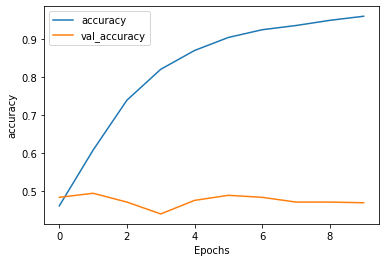

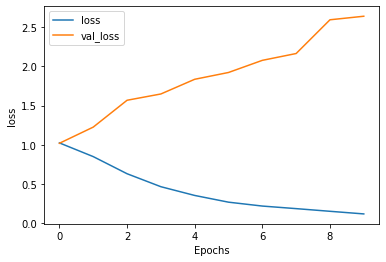

In [28]:
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

In [25]:
embed_size = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True, ),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=10)

Epoch 1/10
634/634 [==============================] - 19s 30ms/step - loss: 1.0953 - accuracy: 0.3685 - val_loss: 1.0841 - val_accuracy: 0.3632
Epoch 2/10
634/634 [==============================] - 18s 29ms/step - loss: 1.0857 - accuracy: 0.3783 - val_loss: 1.0899 - val_accuracy: 0.3899
Epoch 3/10
634/634 [==============================] - 18s 28ms/step - loss: 1.0947 - accuracy: 0.3705 - val_loss: 1.0904 - val_accuracy: 0.3899
Epoch 4/10
634/634 [==============================] - 18s 28ms/step - loss: 1.0939 - accuracy: 0.3740 - val_loss: 1.0893 - val_accuracy: 0.3917
Epoch 5/10
634/634 [==============================] - 18s 28ms/step - loss: 1.0941 - accuracy: 0.3748 - val_loss: 1.0895 - val_accuracy: 0.3908
Epoch 6/10
634/634 [==============================] - 18s 28ms/step - loss: 1.0937 - accuracy: 0.3746 - val_loss: 1.0912 - val_accuracy: 0.3881
Epoch 7/10
634/634 [==============================] - 18s 28ms/step - loss: 1.0831 - accuracy: 0.3776 - val_loss: 1.0631 - val_accuracy:

KeyboardInterrupt: ignored